This kernal is for the "Mode of payment usually used" Task. Like the previous task I did. 

Part 1 of this notebook addressed the other challenge regaurding the most popular taxi company https://www.kaggle.com/schorsi/chicago-taxi-tasks-part-1. I'm currently in week four of my personal challenge to compete one Kaggle task a week.

Thanks to:
   * The city of Chicago for the dataset https://www.kaggle.com/chicago/chicago-taxi-trips-bq
   * Tinotenda for the Task https://www.kaggle.com/tinotendamhlanga

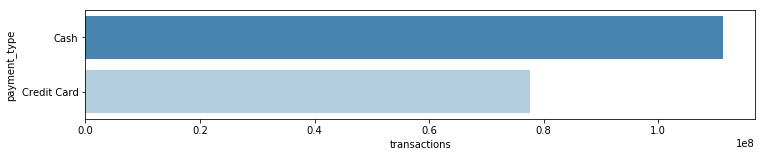

As we can see above, cash is king for the taxi service. See below for the details on how I generated this graph and what other findings I came across

In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd

In [2]:
client = bigquery.Client()
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")
taxi_dat = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.


In [3]:
tables = list(client.list_tables(taxi_dat))
for table in tables:
    print(table.table_id)

taxi_trips


In [4]:
table_ref = dataset_ref.table('taxi_trips')
table = client.get_table(table_ref)
table.schema

[SchemaField('unique_key', 'STRING', 'REQUIRED', 'Unique identifier for the trip.', ()),
 SchemaField('taxi_id', 'STRING', 'REQUIRED', 'A unique identifier for the taxi.', ()),
 SchemaField('trip_start_timestamp', 'TIMESTAMP', 'NULLABLE', 'When the trip started, rounded to the nearest 15 minutes.', ()),
 SchemaField('trip_end_timestamp', 'TIMESTAMP', 'NULLABLE', 'When the trip ended, rounded to the nearest 15 minutes.', ()),
 SchemaField('trip_seconds', 'INTEGER', 'NULLABLE', 'Time of the trip in seconds.', ()),
 SchemaField('trip_miles', 'FLOAT', 'NULLABLE', 'Distance of the trip in miles.', ()),
 SchemaField('pickup_census_tract', 'INTEGER', 'NULLABLE', 'The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.', ()),
 SchemaField('dropoff_census_tract', 'INTEGER', 'NULLABLE', 'The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.', ()),
 SchemaField('pickup_community_area', 'INTEGER', 'NULLABLE', '

In [5]:
## First to see how many payment methods there are total
preliminary_query ="""
SELECT DISTINCT payment_type
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
""" 

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
preliminary_query_job =client.query(preliminary_query,job_config=safe_config)
preliminary_query_result = preliminary_query_job.to_dataframe()
preliminary_query_result.head(10)


,payment_type
0,Mobile
1,Way2ride
2,No Charge
3,Prcard
4,Split
5,Prepaid
6,Dispute
7,Cash
8,Pcard
9,Credit Card


In [6]:
query ="""
SELECT payment_type, COUNT(1) AS transactions
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY payment_type
ORDER BY transactions DESC
""" 

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job =client.query(query,job_config=safe_config)
query_result = query_job.to_dataframe()
query_result.head(10)

,payment_type,transactions
0,Cash,111348005
1,Credit Card,77617402
2,No Charge,810332
3,Unknown,425232
4,Mobile,360386
5,Prcard,274576
6,Dispute,77855
7,Pcard,36874
8,Split,3442
9,Prepaid,1627


In [7]:
query ="""
SELECT payment_type, COUNT(1) AS transactions
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE payment_type = 'Credit Card' OR payment_type = 'Cash'
GROUP BY payment_type
ORDER BY transactions DESC
""" 

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job =client.query(query,job_config=safe_config)
query_result = query_job.to_dataframe()
query_result.head(10)

,payment_type,transactions
0,Cash,111348005
1,Credit Card,77617402


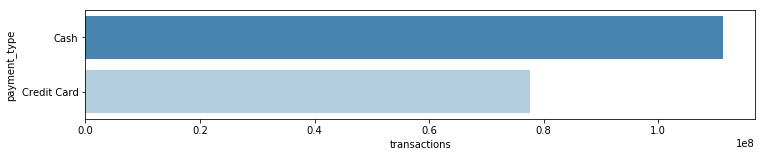

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12, 2))
sns.barplot(x=query_result['transactions'],y=query_result['payment_type'], palette='Blues_r')
#generating the graph pictured above

# Initial findings:
I was not expecting there to be so many different payment methods used. Though it would appear that cash and credit card are used in about 99.9% of all transactions. Next I want to graph card/cash usage over time. The horizontal bar graph above answers the question sufficiently, however I've answered the last 3 tasks with horizontal bar charts so I want to try something else.

In [9]:
query ="""
SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, payment_type, COUNT(1) AS transactions
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE payment_type = 'Credit Card' OR payment_type = 'Cash'
GROUP BY year, payment_type
ORDER BY year, transactions DESC
""" 

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job =client.query(query,job_config=safe_config)
query_result = query_job.to_dataframe()
query_result.head(10)

,year,payment_type,transactions
0,2013,Cash,18708952
1,2013,Credit Card,8099398
2,2014,Cash,23869993
3,2014,Credit Card,13301279
4,2015,Cash,18352793
5,2015,Credit Card,13829228
6,2016,Cash,17818713
7,2016,Credit Card,13775750
8,2017,Cash,13746691
9,2017,Credit Card,11072099


Looking above, what I really want is a table where the years are the index and cash and credit card are the two columns.

I like to believe that one day I will return to this notebook and add the correct query to magically generate that table. But for now in stead I will create that table with python instead.

In [10]:
years = [2013,2014,2015,2016,2017,2018,2019,2020]
ind = 0
cash = []
cc = []
for num in query_result.transactions:
    if ind % 2 == 0:
        cash = cash + [num]
        ind += 1
    else:
        cc = cc + [num]
        ind += 1
cash = pd.Series(cash, index=years, name='Cash')
cash = pd.DataFrame(cash, index=cash.index)
cc = pd.Series(cc, index=years, name='Credit_Card')
cc = pd.DataFrame(cc, index=cash.index)

#The irony of using python for a join when I initially chose this project to practice SQL is not lost on me
pay_df = pd.merge(cash, cc, left_index=True, right_index=True)
pay_df

,Cash,Credit_Card
2013,18708952,8099398
2014,23869993,13301279
2015,18352793,13829228
2016,17818713,13775750
2017,13746691,11072099
2018,10764037,9684665
2019,8086770,7854953
2020,56,30


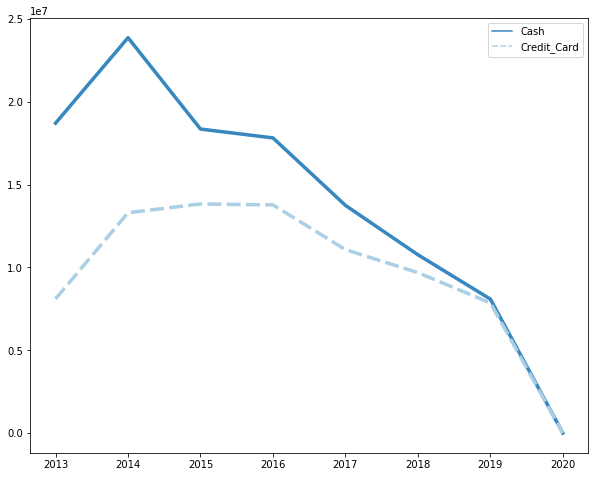

In [11]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=pay_df, palette="Blues_r", linewidth=3.5)


# Final Thoughts:
For the graph above the report was run in January 2020 so there hasn't been much activity recorded yet. There is a downward trend, but not as extreme as this graph would imply.

I find it interesting that cash has had such a large role in the business model of taxi services. While I didn't look at what the totals were, it might be interesting to see if there is a signifigant delta in the average fare for the two catagories. 

It also raises an interesting idea: is the payment method the cause of success of ridesharing services of Uber/Lyft based on the level of purchase friction. Purchase friction is the psycological burden of closing a transaction, for payment methods cash has the highest friction whereas credit cards/mobile pay is the lowest mobile pay has a fast and simple process time and you never handle the money that you give over. For an example of this in action just lookup the average cart comparison between payment methods, for vending machines the difference is about a 33% difference is average amount spent when comparing cash to cards. 

I'm always up to constructive feedback, feel free to comment this article or message me directly. If you would like to collaborate on a future weekly task let me know.

For past examples of my kaggle tasks view my profile or you can also view them on github at: https://github.com/Neil-Kloper/Weekly-Kaggle-Task